In [1]:
from __future__ import print_function, division
import pandas as pd
from meye import MEImage
from scipy import signal as sg
from scipy.ndimage.filters import maximum_filter
import matplotlib.patches as patches
%pylab inline
plt.rcParams['image.cmap'] = 'gray'

Populating the interactive namespace from numpy and matplotlib


In [2]:
df = pd.read_pickle("store.pickle")
# df.head()

# step 1

In [3]:
sobel_kernel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]) / 8
sobel_kernel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]]) / 8

In [7]:
line_zero = df.iloc[0]
curr_rect = line_zero.currRect
prev_rect = line_zero.prevRect
# curr_rect

In [8]:
cimage = MEImage.from_file(line_zero.currImage)
pimage = MEImage.from_file(line_zero.prevImage)

In [109]:
# plt.imshow(pimage.im,cmap='gray',origin='lower')
# plt.imshow(cimage.im,cmap='gray')

In [9]:
prev_rect_mat = pimage.im[prev_rect[2]:prev_rect[3],prev_rect[0]:prev_rect[1]]
curr_rect_mat = cimage.im[curr_rect[2]:curr_rect[3],curr_rect[0]:curr_rect[1]]

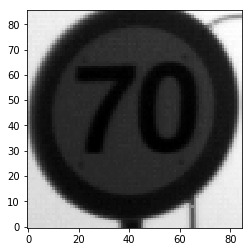

In [10]:
# plt.imshow(prev_rect_mat,cmap='gray',origin='lower')
plt.imshow(curr_rect_mat,cmap='gray',origin='lower')

In [11]:
prev_dx = sg.convolve2d(prev_rect_mat, sobel_kernel_x, "same")
prev_dy = sg.convolve2d(prev_rect_mat, sobel_kernel_y, "same") 

In [12]:
# plt.imshow(prev_dx,cmap='gray',origin='lower')
# plt.imshow(prev_dy,cmap='gray',origin='lower')

In [13]:
max_prev_dx = maximum_filter(prev_dx, 5)
max_prev_dy = maximum_filter(prev_dy, 5)

In [14]:
# plt.imshow(max_prev_dx,cmap='gray',origin='lower')
# plt.imshow(max_prev_dy,cmap='gray',origin='lower')

# step 2

In [15]:
prev_mat_xx = prev_dx ** 2
prev_mat_yy = prev_dy * prev_dy
prev_mat_xy = prev_dx ** 2

# step 3 4 5

In [16]:
patch_filter = np.ones((5,5)) / 9
# patch_filter

In [17]:
sxx = sg.convolve2d(prev_mat_xx, patch_filter, "same")
sxy = sg.convolve2d(prev_mat_xy, patch_filter, "same")
syy = sg.convolve2d(prev_mat_yy, patch_filter, "same")

In [21]:
for x in range(prev_rect_mat.shape[0]):
    for y in range(prev_rect_mat.shape[1]):
        sxx[x][y] = prev_mat_xx[x-2:x+2,y-2:y+2].sum()
        sxy[x][y] = prev_mat_xy[x-2:x+2,y-2:y+2].sum()
        syy[x][y] = prev_mat_yy[x-2:x+2,y-2:y+2].sum()

In [30]:
R = np.zeros((prev_mat_xx.shape[0]-4,prev_mat_xx.shape[1]-4))
k = 0.05

In [42]:
for x in range(2,prev_rect_mat.shape[0]-2):
    for y in range(2,prev_rect_mat.shape[1]-2):
#         print(f"({x},{y})")
        fsxx = (prev_mat_xx[x-2:x+2,y-2:y+2]*(1/9)).sum()
        fsxy = (prev_mat_xy[x-2:x+2,y-2:y+2]*(1/9)).sum()
        fsyy = (prev_mat_yy[x-2:x+2,y-2:y+2]*(1/9)).sum()
        
        H = np.array([[fsxx, fsxy], [fsxy, fsyy]])
#         R[x-2][y-2] = np.linalg.det(H) - k*((np.trace(H))**2)
        R[x-2][y-2] = 2*(np.linalg.det(H)/(np.trace(H) + 0.01))

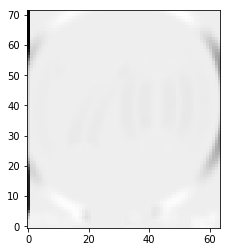

In [43]:
plt.imshow(R,cmap='gray',origin='lower')

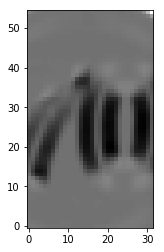

In [44]:
plt.imshow(R[15:70,18:50],cmap='gray',origin='lower')

In [45]:
max_R = maximum_filter(R, 5)

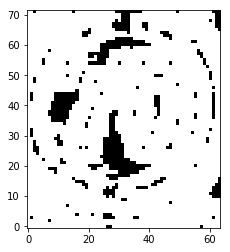

In [51]:
mask = np.zeros((prev_mat_xx.shape[0]-4,prev_mat_xx.shape[1]-4))
mask[(R - max_R)**2 > 1 ] = 1
plt.imshow(mask,cmap='gray',origin='lower')

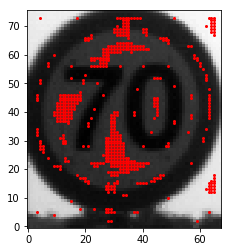

In [58]:
plt.imshow(prev_rect_mat,cmap='gray',origin='lower')
for x in range(2,prev_rect_mat.shape[0]-2):
    for y in range(2,prev_rect_mat.shape[1]-2):
        if not mask[x-2][y-2]:
            plt.scatter(y,x, c='r', s=4)